# The Chi^2 godness-of-fit test

I want to perform a Chi^2-gof test comparing the observed mutation distribution with what we would expect. Our expectation has been calculated in a different script. One test will be general, dividing expectations into sex and sample-type, and 18 will be cancer-specific.

## Setup

In [1]:
suppressWarnings({
library("ggplot2")
library("ggpattern")
library('dplyr')
library('ggrepel')
})


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# We define our age-interval order
age_interval_levels <- c('<45',
                         '[45-55[',
                         '[55-65[',
                         '[65-75[',
                         '>=75')

## Loading general Data

In [3]:
general_expectation <- read.csv("../../derived_data/chi2_gof_test_expectations/general.csv", header=TRUE, stringsAsFactors=FALSE)

general_expectation <- general_expectation %>% select(-X)

general_expectation$age_interval <- factor(general_expectation$age_interval, levels=age_interval_levels)

dim(general_expectation)
head(general_expectation)

[1] 33820     5

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,hypothesis_freq
,<chr>,<fct>,<chr>,<chr>,<dbl>
1,MUTYH,<45,Male,Primary,0.3418843
2,FGF19,<45,Male,Primary,0.3418843
3,DDR2,<45,Male,Primary,0.3418843
4,HRAS,<45,Male,Primary,0.3418843
5,CDKN2A,<45,Male,Primary,0.3418843
6,TP53,<45,Male,Primary,0.3418843


In [4]:
# We load the pathogen data, only containing pathogens tested for in >=50% of patients
pathogen <- read.csv("../../derived_data/genie_v15/pathogen_filtered_50.csv")

# Checking the dimensions and look of the table
dim(pathogen)
head(pathogen)

[1] 511408     23

,Hugo_Symbol,sample_id,SIFT_Prediction,Polyphen_Prediction,Variant_Classification,gnomAD_AMR_AF,gnomAD_NFE_AF,Population,Pathogen,patient_id,⋯,dead,age,oncotree_code,sample_type,sequence_assay_ID,cancer_type,sample_type_detail,population,age_group,age_interval
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,KRAS,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,0.00000e+00,0.00000e+00,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
2,BRAF,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,0.00000e+00,0.00000e+00,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
3,EGFR,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,2.89101e-05,3.51673e-05,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
4,CTNNB1,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,NA,NA,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
5,PIK3CA,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,NA,NA,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
6,CDKN2A,GENIE-JHU-00006-00185,NA,NA,Nonsense_Mutation,NA,NA,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[


In [5]:
# We also load the cmc data
cmc <- read.table(file = "../../data/annotation/Census_all_driver_genes.tsv", sep="\t", quote="", header=TRUE)

# And check dimensions
dim(cmc)
# And have a look at the table
#head(cmc)

[1] 743  20

## Selection and Wrangling

In [6]:
# We select the columns of interest from the pathogen data
pathogen <- pathogen %>% select('Hugo_Symbol','sample_id','patient_id','age','age_group','sex','sample_type', 'cancer_type')

In [7]:
# Define our age-intervals
pathogen$age_interval <- '<45'
pathogen$age_interval[pathogen$age>=45] <- '[45-55['
pathogen$age_interval[pathogen$age>=55] <- '[55-65['
pathogen$age_interval[pathogen$age>=65] <- '[65-75['
pathogen$age_interval[pathogen$age>=75] <- '>=75'

# And use them to make age-interval a factor in our pathogen data
pathogen$age_interval <- factor(pathogen$age_interval, levels=age_interval_levels)

In [8]:
pathogen$SEX <- NA

pathogen <- pathogen %>% mutate(SEX = case_when(sex == 'Female' ~ 'Female',
                                                sex == 'Male' ~ 'Male'))

pathogen$SAMPLE_TYPE <- NA

pathogen <- pathogen %>% mutate(SAMPLE_TYPE = case_when(sample_type == 'Primary' ~ 'Primary',
                                                        sample_type == 'Metastasis' ~ 'Metastasis'))

pathogen <- na.omit(pathogen)

pathogen <- pathogen %>% select(-sex, -sample_type)

In [9]:
# And then we remove duplicates from the dataset
pathogen <- pathogen[!duplicated(pathogen[,]),]

dim(pathogen)

[1] 408661      9

## general Observation

In [10]:
observed_mutations <- pathogen %>%
# We first group by age interval, and then by mutation
  group_by(Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE) %>%
# We find how often that mutation occurs in that age group
  summarise(n = n())

observed_mutations$age_interval <- factor(observed_mutations$age_interval, levels=age_interval_levels)

observed_mutations <- as.data.frame(observed_mutations)

`summarise()` has grouped output by 'Hugo_Symbol', 'age_interval', 'SEX'. You can override using the
`.groups` argument.


In [11]:
head(observed_mutations)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n
,<chr>,<fct>,<chr>,<chr>,<int>
1,ABL1,<45,Female,Metastasis,9
2,ABL1,<45,Female,Primary,29
3,ABL1,<45,Male,Metastasis,13
4,ABL1,<45,Male,Primary,20
5,ABL1,[45-55[,Female,Metastasis,24
6,ABL1,[45-55[,Female,Primary,51


In [12]:
# Even if there are no mutations in a specific age-group we still need a count and frequency
# So we add these 0-rows manually

# We run through each of the new age-intervals
for (age_lvl in age_interval_levels){
    
    # And each unique mutation
    for (mut in unique(observed_mutations$Hugo_Symbol)){
        
        # We create a temporary dataframe containing only rows with our mutation, age, sex and sample-type
        
        # We start with male-primary
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        
        # If the dataframe is empty we need to add that row to our mutation frequency datatable
        if (nrow(tmp)==0){
            # We add the mutation
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            # The age
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            # The sex
            observed_mutations[nrow(observed_mutations), 3] = 'Male'
            # The sample-type
            observed_mutations[nrow(observed_mutations), 4] = 'Primary'
            # And the count
            observed_mutations[nrow(observed_mutations), 5] = 0
        }
        
        # Then male-metastasis
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        
        # If the dataframe is empty we need to add that row to our mutation frequency datatable
        if (nrow(tmp)==0){
            # We add the mutation
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            # The age
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            # The sex
            observed_mutations[nrow(observed_mutations), 3] = 'Male'
            # The sample-type
            observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
            # And the count
            observed_mutations[nrow(observed_mutations), 5] = 0
        }

        # Then female-primary
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        
        # If the dataframe is empty we need to add that row to our mutation frequency datatable
        if (nrow(tmp)==0){
            # We add the mutation
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            # The age
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            # The sex
            observed_mutations[nrow(observed_mutations), 3] = 'Female'
            # The sample-type
            observed_mutations[nrow(observed_mutations), 4] = 'Primary'
            # And the count
            observed_mutations[nrow(observed_mutations), 5] = 0
        }
        
        # and finally female-metastasis
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        
        # If the dataframe is empty we need to add that row to our mutation frequency datatable
        if (nrow(tmp)==0){
            # We add the mutation
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            # The age
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            # The sex
            observed_mutations[nrow(observed_mutations), 3] = 'Female'
            # The sample-type
            observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
            # And the count
            observed_mutations[nrow(observed_mutations), 5] = 0
        }
        
    }
}

In [13]:
head(observed_mutations)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n
,<chr>,<fct>,<chr>,<chr>,<dbl>
1,ABL1,<45,Female,Metastasis,9
2,ABL1,<45,Female,Primary,29
3,ABL1,<45,Male,Metastasis,13
4,ABL1,<45,Male,Primary,20
5,ABL1,[45-55[,Female,Metastasis,24
6,ABL1,[45-55[,Female,Primary,51


In [14]:
# We save the results
write.csv(observed_mutations, "../../derived_data/chi2_gof_test_observations/general.csv", row.names=TRUE)

## The general Test

In [15]:
# Create an empty data-table which will hold the chi-squared gof results
chi_squared_gof <- data.frame(matrix(ncol = 7, nrow = 0))
# We name the columns
colnames(chi_squared_gof) <- c('Hugo_Symbol', 'sex', 'sample_type', 'X_squared', 'df','p_value')

# We run through all the mutations
for (mut in unique(general_expectation$Hugo_Symbol)){
    
    if (mut %in% unique(observed_mutations$Hugo_Symbol)){
        
        # We define our four expectations (easier than a billion for-loops)

        # Male-Primary
        exp_mp <- general_expectation[which(general_expectation$Hugo_Symbol==mut & general_expectation$SEX=='Male' & general_expectation$SAMPLE_TYPE=='Primary'),5]
        
        # Female-Primary
        exp_fp <- general_expectation[which(general_expectation$Hugo_Symbol==mut & general_expectation$SEX=='Female' & general_expectation$SAMPLE_TYPE=='Primary'),5]

        # Male-Metastasis
        exp_mm <- general_expectation[which(general_expectation$Hugo_Symbol==mut & general_expectation$SEX=='Male' & general_expectation$SAMPLE_TYPE=='Metastasis'),5]

        # Female-Metastasis
        exp_fm <- general_expectation[which(general_expectation$Hugo_Symbol==mut & general_expectation$SEX=='Female' & general_expectation$SAMPLE_TYPE=='Metastasis'),5]


        # We define our four observations

        # Male-Primary
        obs_mp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        # We make sure that the observations are in the correct order
        obs_mp <- obs_mp[order(obs_mp$age_interval), 5]
        
        # Female-Primary
        obs_fp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        obs_fp <- obs_fp[order(obs_fp$age_interval), 5]
        
        # Male-Metastasis
        obs_mm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        obs_mm <- obs_mm[order(obs_mm$age_interval), 5]
        
        # Female-Metastasis
        obs_fm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        obs_fm <- obs_fm[order(obs_fm$age_interval), 5]

        # We perform our four chi-squared test and add the results to the chi-square-gof-table

        # Male-Primary
        suppressWarnings(chi <- chisq.test(x=obs_mp, p=exp_mp))
        chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Male', 'Primary', chi[1], chi[2], chi[3])    

        # Female-Primary
        suppressWarnings(chi <- chisq.test(x=obs_fp, p=exp_fp))
        chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Female', 'Primary', chi[1], chi[2], chi[3])

        # Male-Metastasis
        suppressWarnings(chi <- chisq.test(x=obs_mm, p=exp_mm))
        chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Male', 'Metastasis', chi[1], chi[2], chi[3])

        # Female-Metastasis
        suppressWarnings(chi <- chisq.test(x=obs_fm, p=exp_fm))
        chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Female', 'Metastasis', chi[1], chi[2], chi[3])
    }
}

# Checking the results
head(chi_squared_gof)

,Hugo_Symbol,sex,sample_type,X_squared,df,p_value,NA
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,MUTYH,Male,Primary,28.383727,4,1.042709e-05,MUTYH
2,MUTYH,Female,Primary,53.947732,4,5.396985e-11,MUTYH
3,MUTYH,Male,Metastasis,32.288692,4,1.670015e-06,MUTYH
4,MUTYH,Female,Metastasis,3.474461,4,4.817722e-01,MUTYH
5,FGF19,Male,Primary,16.788865,4,2.124295e-03,FGF19
6,FGF19,Female,Primary,32.104295,4,1.821462e-06,FGF19


## The general plot

In [16]:
options(repr.plot.width=15, repr.plot.height=8)

In [17]:
length(unique(chi_squared_gof$Hugo_Symbol))

[1] 300

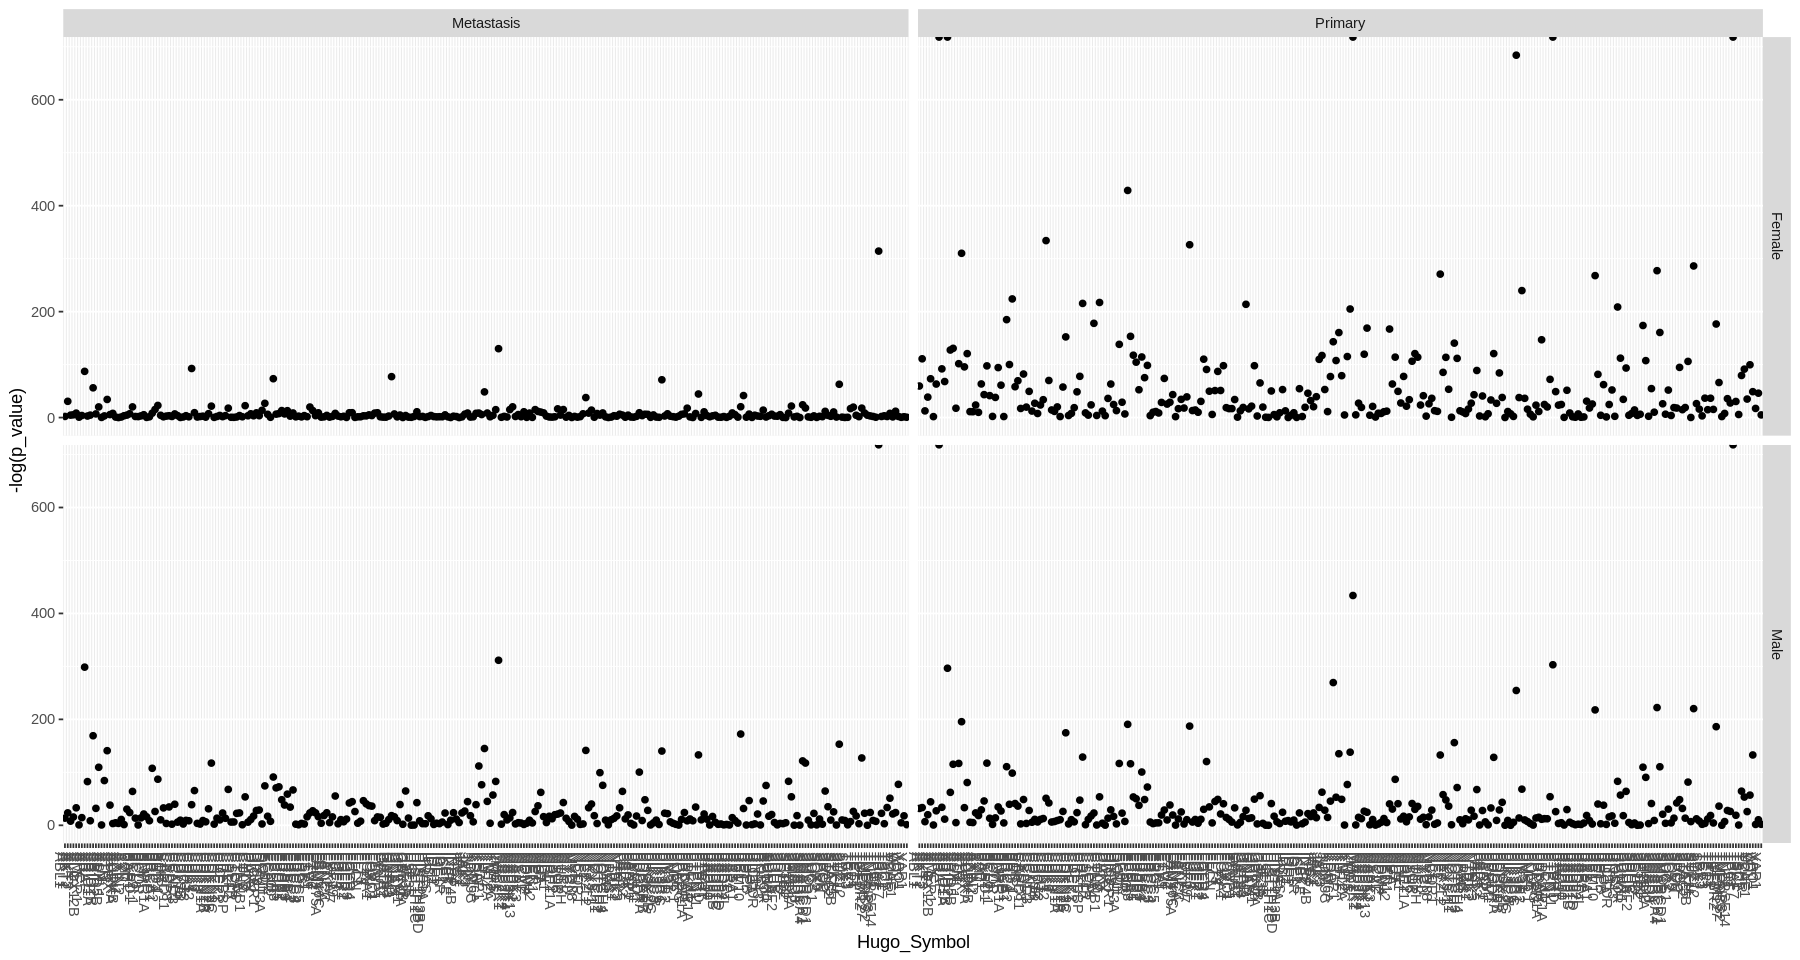

In [18]:
# p-value plot
ggplot(chi_squared_gof, aes(x = Hugo_Symbol, y = -log(p_value))) +
geom_point() +
theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
facet_grid(rows = vars(sex), cols = vars(sample_type))

[1] 44  7

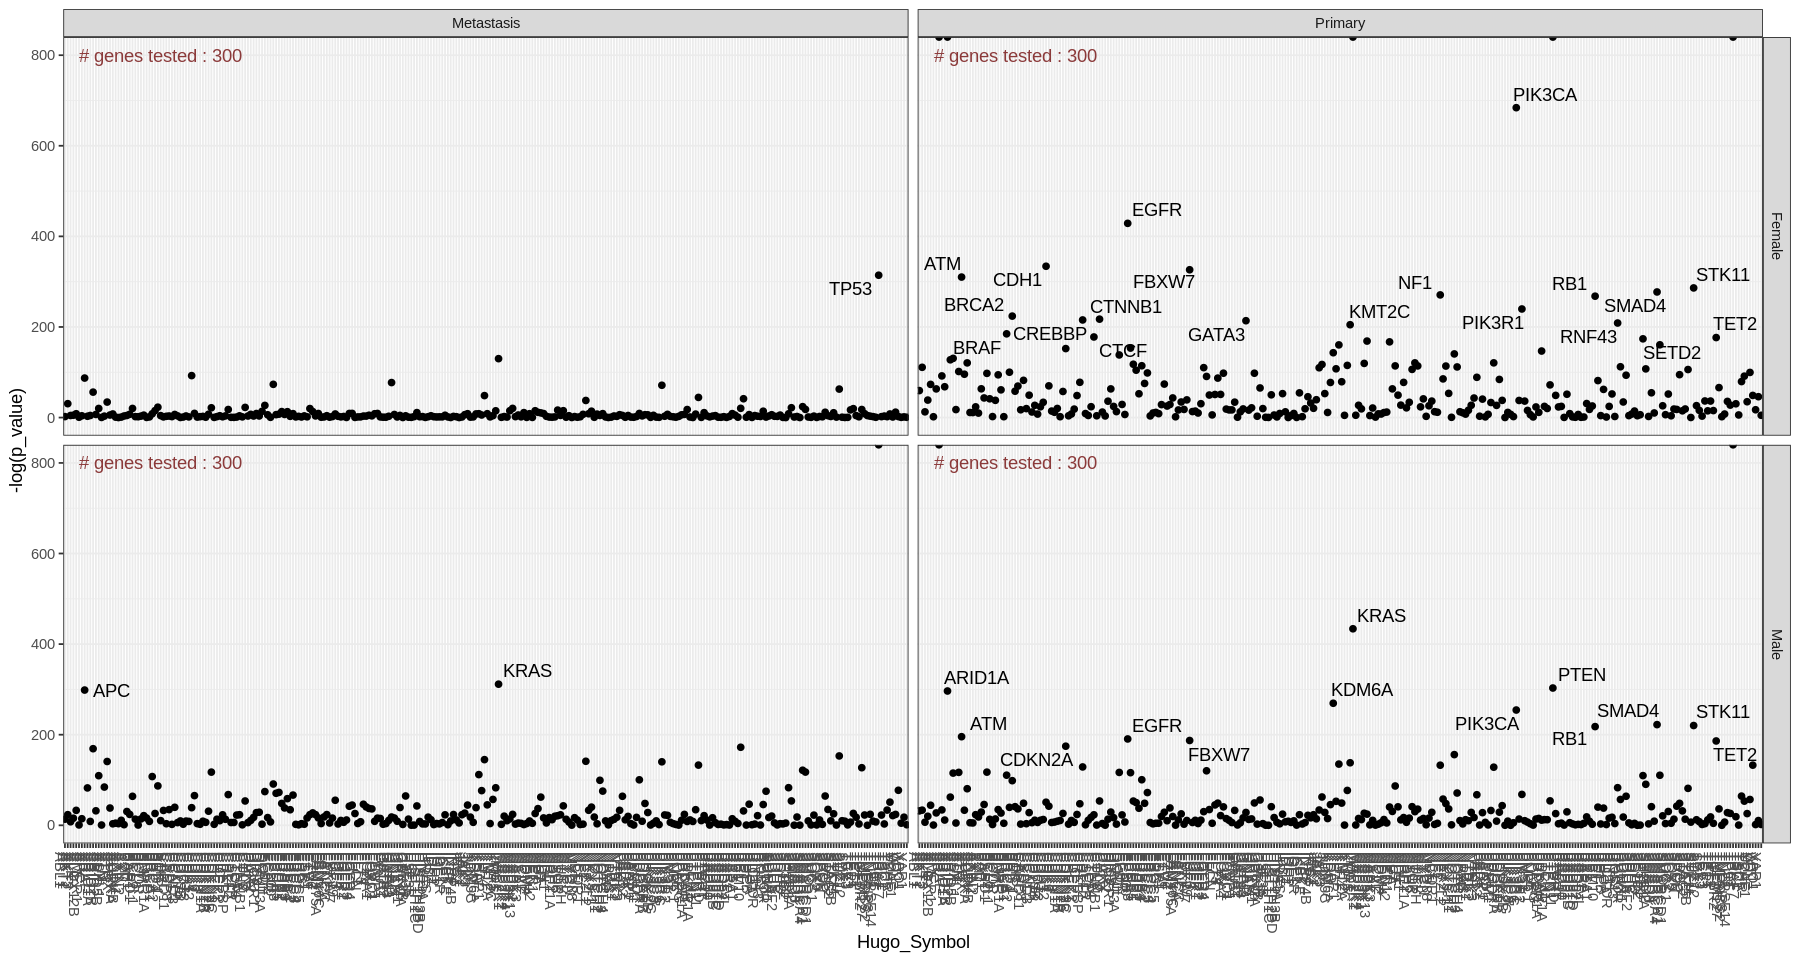

In [19]:
chi_tmp <- chi_squared_gof[which(chi_squared_gof$p_value <= (10**-75)),]
dim(chi_tmp)

p_label <- as.character(length(unique(chi_squared_gof$Hugo_Symbol)))
p_label <- paste('# genes tested : ', p_label, sep="")

ggplot(chi_squared_gof, aes(x = Hugo_Symbol, y = -log(p_value))) +
geom_point() +
facet_grid(rows = vars(sex), cols = vars(sample_type)) +
geom_text_repel(data=chi_tmp, aes(label=Hugo_Symbol), max.overlaps=nrow(chi_tmp)) +
theme_bw() +
theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
annotate("text", x = 35, y = 800, label = p_label, colour = "#8B3A3A")

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_ydensity()`).”


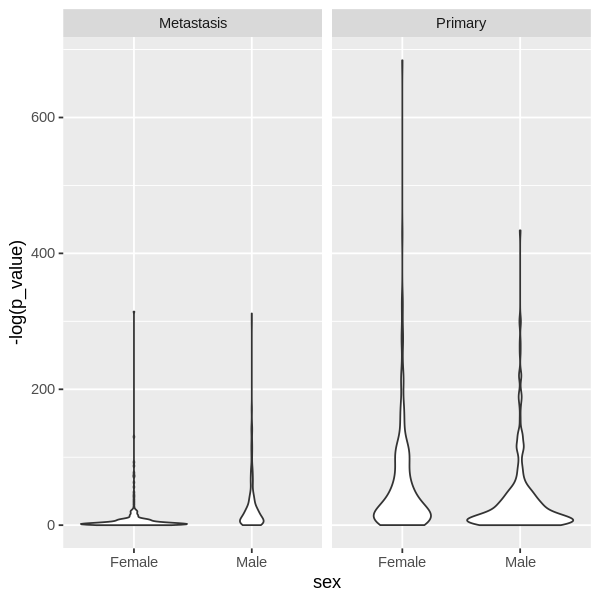

In [20]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(chi_squared_gof, aes(x=sex, y=-log(p_value))) + 
  geom_violin() + 
  facet_wrap(~sample_type)

In [21]:
# Saving hte result

write.csv(chi_squared_gof, "../../derived_data/chi2_gof_test_results/general.csv", row.names=TRUE)

# Cancer-specific ci2-gof test

In [22]:
colnames(pathogen)
head(pathogen)

[1] "Hugo_Symbol"  "sample_id"    "patient_id"   "age"          "age_group"   
[6] "cancer_type"  "age_interval" "SEX"          "SAMPLE_TYPE"

,Hugo_Symbol,sample_id,patient_id,age,age_group,cancer_type,age_interval,SEX,SAMPLE_TYPE
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<fct>,<chr>,<chr>
1,KRAS,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,Non-Small Cell Lung Cancer,[55-65[,Male,Primary
2,BRAF,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,Non-Small Cell Lung Cancer,[55-65[,Male,Primary
3,EGFR,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,Non-Small Cell Lung Cancer,[55-65[,Male,Primary
4,CTNNB1,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,Non-Small Cell Lung Cancer,[55-65[,Male,Primary
5,PIK3CA,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,Non-Small Cell Lung Cancer,[55-65[,Male,Primary
6,CDKN2A,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,Non-Small Cell Lung Cancer,[55-65[,Male,Primary


In [23]:
# We have a list of our different cancer-types
cancer_list <- c('Bladder Cancer',
                 'Breast Cancer',
                 'Cancer of Unknown Primary',
                 'Colorectal Cancer',
                 'Endometrial Cancer',
                 'Esophagogastric Cancer',
                 'Glioma',
                 'Head and Neck Cancer',
                 'Hepatobiliary Cancer',
                 'Mature B-Cell Neoplasms',
                 'Melanoma',
                 'Non-Small Cell Lung Cancer',
                 'Ovarian Cancer',
                 'Pancreatic Cancer',
                 'Prostate Cancer',
                 'Renal Cell Carcinoma',
                 'Soft Tissue Sarcoma',
                 'Thyroid Cancer')

In [24]:
# Silencing the summarise warning from dyplr
options(dplyr.summarise.inform = FALSE)

# We repeat the chi2-gof-test for each cancer-type

for (idx in 1:length(cancer_list)){
    # The name of our cancer
    name <- cancer_list[idx]
    # The name of our cancer-file
    file_name <- gsub(" ", "_", name)
    # The path to our cancer-file as a list
    path_list <- c("../../derived_data/chi2_gof_test_expectations/", file_name, ".csv")
    # Making it a string
    file_path <- paste(path_list, collapse="")
    # Reading in our expectations
    expectations <- read.csv(file_path, header=TRUE, stringsAsFactors=FALSE)
    # Removing a useless column
    expectations <- expectations %>% select(-X)
    # Setting the age-intervals
    expectations$age_interval <- factor(expectations$age_interval, levels=age_interval_levels)

    # Selecting only pathogens found in in our cancer-type
    cancer_pathogen <- pathogen[which(pathogen$cancer_type == name),]

    # From here it is the same process as before
    # New sections will be commented on
    
    observed_mutations <- cancer_pathogen %>%
      group_by(Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE) %>%
      summarise(n = n())

    observed_mutations$age_interval <- factor(observed_mutations$age_interval, levels=age_interval_levels)

    observed_mutations <- as.data.frame(observed_mutations)
    
    chi_squared_gof <- data.frame(matrix(ncol = 6, nrow = 0))
    
    colnames(chi_squared_gof) <- c('Hugo_Symbol', 'sex', 'sample_type', 'X_squared', 'df','p_value')
    
    # We start with the normal case where there are wo sexes and sample types
    if (length(unique(expectations$SEX)) == 2){
        for (age_lvl in age_interval_levels){
            for (mut in unique(observed_mutations$Hugo_Symbol)){
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Male'
                    observed_mutations[nrow(observed_mutations), 4] = 'Primary'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Male'
                    observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Female'
                    observed_mutations[nrow(observed_mutations), 4] = 'Primary'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Female'
                    observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }        
            }
        }
        
        for (mut in unique(expectations$Hugo_Symbol)){
            if (mut %in% unique(observed_mutations$Hugo_Symbol)){
                exp_mp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Male' & expectations$SAMPLE_TYPE=='Primary'),6]
                exp_fp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Female' & expectations$SAMPLE_TYPE=='Primary'),6]
                exp_mm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Male' & expectations$SAMPLE_TYPE=='Metastasis'),6]
                exp_fm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Female' & expectations$SAMPLE_TYPE=='Metastasis'),6]
                
                obs_mp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                obs_mp <- obs_mp[order(obs_mp$age_interval), 5]
                obs_fp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                obs_fp <- obs_fp[order(obs_fp$age_interval), 5]
                obs_mm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                obs_mm <- obs_mm[order(obs_mm$age_interval), 5]
                obs_fm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                obs_fm <- obs_fm[order(obs_fm$age_interval), 5]
                
                # Some mutations might not have any observed mutations in any age-interval for a specific sex-sample-type group,
                # so only if the sum of our observations are different than 0 can we test it
                if (sum(obs_mp) != 0){
                    suppressWarnings(chi <- chisq.test(x=obs_mp, p=exp_mp))
                    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Male', 'Primary', chi[1], chi[2], chi[3])             
                }
                
                if (sum(obs_fp) != 0){
                    suppressWarnings(chi <- chisq.test(x=obs_fp, p=exp_fp))
                    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Female', 'Primary', chi[1], chi[2], chi[3])
                }
                
                if (sum(obs_mm) != 0){
                    suppressWarnings(chi <- chisq.test(x=obs_mm, p=exp_mm))
                    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Male', 'Metastasis', chi[1], chi[2], chi[3])
                }

                if (sum(obs_fm) != 0){
                    suppressWarnings(chi <- chisq.test(x=obs_fm, p=exp_fm))
                    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, 'Female', 'Metastasis', chi[1], chi[2], chi[3])
                }
            }
        }  
    } else if (length(unique(expectations$SEX)) == 1) {
        
        the_sex <- unique(expectations$SEX)
        
        for (age_lvl in age_interval_levels){
            for (mut in unique(observed_mutations$Hugo_Symbol)){
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Primary'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = the_sex
                    observed_mutations[nrow(observed_mutations), 4] = 'Primary'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = the_sex
                    observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }        
            }
        }
        
        for (mut in unique(expectations$Hugo_Symbol)){
            if (mut %in% unique(observed_mutations$Hugo_Symbol)){
                
                exp_xp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX==the_sex & expectations$SAMPLE_TYPE=='Primary'),6]
                exp_xm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX==the_sex & expectations$SAMPLE_TYPE=='Metastasis'),6]

                obs_xp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Primary'),]
                obs_xp <- obs_xp[order(obs_xp$age_interval), 5]
                obs_xm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                obs_xm <- obs_xm[order(obs_xm$age_interval), 5]
                
                if (sum(obs_xp) != 0){
                    suppressWarnings(chi <- chisq.test(x=obs_xp, p=exp_xp))
                    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, the_sex, 'Primary', chi[1], chi[2], chi[3])
                }

                if (sum(obs_xm) != 0){
                    suppressWarnings(chi <- chisq.test(x=obs_xm, p=exp_xm))
                    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut, the_sex, 'Metastasis', chi[1], chi[2], chi[3])
                }
            }
        }        
    }
    
    # We define the file-path for our results as a list
    path_list <- c("../../derived_data/chi2_gof_test_results/", file_name, ".csv")
    # Then we make it a string
    file_path <- paste(path_list, collapse="")
    # And save the result
    write.csv(chi_squared_gof, file_path, row.names=TRUE)
}

ERROR: Error in if (any(p < 0)) stop("probabilities must be non-negative."): missing value where TRUE/FALSE needed


## The cancer-specific plots

In [25]:
for (idx in 1:length(cancer_list)){
    # The name of our cancer
    name <- cancer_list[idx]
    # The name of our cancer-file
    file_name <- gsub(" ", "_", name)
    # The path to our cancer-file as a list
    path_list <- c("../../derived_data/chi2_gof_test_results/", file_name, ".csv")
    #Making it a string
    file_path <- paste(path_list, collapse="")
    # Reading in our expectations
    results <- read.csv(file_path, header=TRUE, stringsAsFactors=FALSE)
    # Removing a useless column
    results <- results %>% select(-X)

    # We want to plot the results and save them

    # We make a smaller data-frame contrining genes with very high p-values for labelling
    cut_off <- quantile(results$p_value, probs = 0.025)
    chi_tmp <- results[which(results$p_value <= cut_off),]

    # I want a label on my plot showing how many genes are tested and which cancer it is for
    n_tests <- as.character(length(unique(results$Hugo_Symbol)))
    
    n_tests <- c(name, '\n# genes tested : ', n_tests)
    p_label <- paste(n_tests, collapse="")
    
    if (length(unique(results$sex)) == 2){
        # The acctual plot
        ggplot(results, aes(x = Hugo_Symbol, y = -log(p_value))) +
        geom_point() +
        facet_grid(rows = vars(sex), cols = vars(sample_type)) +
        geom_text_repel(data=chi_tmp, aes(label=Hugo_Symbol), max.overlaps=nrow(chi_tmp)) +
        theme_bw() +
        theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
        ggtitle(p_label)
        
        # Saving the plot
        path_list <- c("../../figures/chi2_gof_test/", file_name, ".pdf")
        file_path <- paste(path_list, collapse="")
        ggsave(file_path, width = 20, height = 20, units = "cm") 
        
    }else if (length(unique(results$sample_type)) == 2){
        # The acctual plot
        ggplot(results, aes(x = Hugo_Symbol, y = -log(p_value))) +
        geom_point() +
        facet_wrap(~sample_type) +
        geom_text_repel(data=chi_tmp, aes(label=Hugo_Symbol), max.overlaps=nrow(chi_tmp)) +
        theme_bw() +
        theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
        ggtitle(p_label)
        
        # Saving the plot
        path_list <- c("../../figures/chi2_gof_test/", file_name, ".pdf")
        file_path <- paste(path_list, collapse="")
        ggsave(file_path, width = 20, height = 20, units = "cm") 
    }else{
        # If there are any cancer-types with <2 sexes and sample-types,
        # we want to know what they are
        print(name)
    }   
}

[1] "Non-Small Cell Lung Cancer"


## Explaining the empty Non-Small Cell Lung Cancer plot

In [ ]:
# The name of our cancer-file
file_name <- gsub(" ", "_", "Non-Small Cell Lung Cancer")
# The path to our cancer-file as a list
path_list <- c("../../derived_data/chi2_gof_test_expectations/", file_name, ".csv")
#Making it a string
file_path <- paste(path_list, collapse="")
# Reading in our expectations
results <- read.csv(file_path, header=TRUE, stringsAsFactors=FALSE)
# Removing a useless column
results <- results %>% select(-X)

# How many cancer-pathogens do we have?
cancer_pathogen <- pathogen[which(pathogen$cancer_type == name),]

vect1 <- unique(cancer_pathogen$Hugo_Symbol)
vect2 <- unique(results$Hugo_Symbol)

both <- intersect(vect1,vect2)

print('--- cancer pathogens ---')
print(nrow(cancer_pathogen))
print('--- cancer mutations ---')
print(length(unique(results$Hugo_Symbol)))
print('--- in both ---')
print(length(both))

In [ ]:
for (idx in 1:length(cancer_list)){
    # The name of our cancer
    name <- cancer_list[idx]
    # The name of our cancer-file
    file_name <- gsub(" ", "_", name)
    # The path to our cancer-file as a list
    path_list <- c("../../derived_data/chi2_gof_test_expectations/", file_name, ".csv")
    #Making it a string
    file_path <- paste(path_list, collapse="")
    # Reading in our expectations
    results <- read.csv(file_path, header=TRUE, stringsAsFactors=FALSE)
    # Removing a useless column
    results <- results %>% select(-X)

    # How many cancer-pathogens do we have?
    cancer_pathogen <- pathogen[which(pathogen$cancer_type == name),]

    vect1 <- unique(cancer_pathogen$Hugo_Symbol)
    vect2 <- unique(results$Hugo_Symbol)
    
    both <- intersect(vect1,vect2)
    print('--- in both ---')
    print(name)
    print(length(both))
}